In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from random import randint

from scipy import random
from scipy.stats import uniform
from scipy.spatial.distance import euclidean
from scipy.stats import norm
import scipy.linalg as la
import matplotlib.colors as mcolors

from toolbox.exact_barycenter import *
from toolbox.pga import *
from toolbox.tools_signal import *
from toolbox.geodesic import *



import ot

matplotlib.rcParams.update({'font.size': 20, 'legend.fontsize': 20})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Toy example for logistic regression

In [7]:
np.random.seed(3)

N = 100
support = 1000

# generate random means and variances
means = random.uniform(low=10, high=25, size=N)
variances = random.uniform(low=1, high=2, size=N)
x = np.linspace(-20, 50, support) 

C0 = np.zeros((N,support)) # space for class 0 
C1 = np.zeros((N,support)) # space for class 1

cste = 8
for i, (mean, v) in enumerate(zip(means, variances)):
    C0[i, :] = 1/2 * norm.pdf(x, loc=mean+8, scale=v/2) + 1/2 * norm.pdf(x, loc=mean-8, scale=v*2)
    C1[i, :] = 1/2 * norm.pdf(x, loc=mean-8, scale=v/2) + 1/2 * norm.pdf(x, loc=mean+8, scale=v*2)    

# get normalized measure
for i in range(C0.shape[0]):
    C0[i,:] = C0[i,:] / np.sum(C0[i, :])
for i in range(C1.shape[0]):
    C1[i,:] = C1[i,:] / np.sum(C1[i, :])   

bar0, C0_inv, bar0_inv, _ = get_barycenter(C0, x, 10000)
bar1, C1_inv, bar1_inv, _ = get_barycenter(C1, x, 10000)

# create the dataset 
y = np.concatenate([np.zeros(N,), np.ones(N,)])
X = np.concatenate([C0, C1])
n,d = X.shape

# L2 bar
L2_bar0 = np.mean(X[y==0, :], axis=0)
L2_bar1 = np.mean(X[y==1, :], axis=0)


In [8]:

wass_dist = np.zeros((X.shape[0],2))

wass_dist[:N,0] = get_distance(C0_inv, bar0_inv)
wass_dist[N:,0] = get_distance(C0_inv, bar1_inv)
wass_dist[:N,1] = get_distance(C1_inv, bar0_inv)
wass_dist[N:,1] = get_distance(C0_inv, bar0_inv)
wass_dist = np.sqrt(wass_dist)
    
XX = np.zeros((n,2))
for j, m in enumerate(X):
    XX[j, 0] = euclidean(m, L2_bar0)
    XX[j, 1] = euclidean(m, L2_bar1)



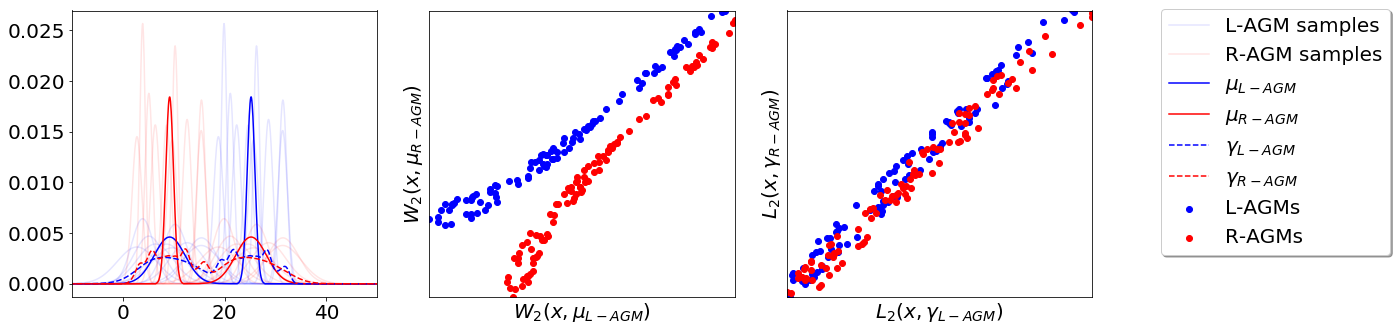

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,5)) 


ax[0].plot(x, C0[1:10, :].T, alpha = 0.1, color='b')
ax[0].plot(x, C1[1:10,:].T, alpha = 0.1, color='r')
l1, = ax[0].plot(x, C0[0, :].T, alpha = 0.1, color='b', label='L-AGM samples')
l2, = ax[0].plot(x, C1[0,:].T, alpha = 0.1, color='r', label='R-AGM samples')

ax[0].set_xlim([-10, 50])
l3, = ax[0].plot(x, bar0, label='$\mu_{L-AGM}$', color='b')
l4, = ax[0].plot(x, bar1, label='$\mu_{R-AGM}$', color='r')
l5, = ax[0].plot(x, L2_bar0, label='$\gamma_{L-AGM}$', color='b', linestyle='--')
l6, = ax[0].plot(x, L2_bar1, label='$\gamma_{R-AGM}$', color='r', linestyle='--')

ax[1].set_xlim([np.min(wass_dist[:,0]), np.max(wass_dist[:,0])])
ax[1].set_ylim([np.min(wass_dist[:,1]), np.max(wass_dist[:,1])])
l7 = ax[1].scatter(wass_dist[y==0, 0], wass_dist[y==0, 1], color='b', label="L-AGMs")
l8 = ax[1].scatter(wass_dist[y==1, 0], wass_dist[y==1, 1], color='r', label="R-AGMs")
ax[1].set_xlabel("$W_2(x,\mu_{L-AGM})$", fontsize=20)
ax[1].set_ylabel("$W_2(x,\mu_{R-AGM})$", fontsize=20)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].set_xlim([np.min(XX[:,0]), np.max(XX[:,0])])
ax[2].set_ylim([np.min(XX[:,1]), np.max(XX[:,1])])
ax[2].scatter(XX[y==0, 0], XX[y==0, 1], color='b', label="0")
ax[2].scatter(XX[y==1, 0], XX[y==1, 1], color='r', label="1")
ax[2].set_xlabel("$L_2(x,\gamma_{L-AGM})$", fontsize=20)
ax[2].set_ylabel("$L_2(x,\gamma_{R-AGM})$", fontsize=20)
ax[2].set_xticks([])
ax[2].set_yticks([])


plt.legend(handles=[l1, l2, l3, l4, l5, l6, l7, l8], loc='upper center', bbox_to_anchor=(1.6, 1.04), ncol=1, fancybox=True, shadow=True, fontsize=20)


plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig('figures/toy_example.pdf')
plt.show()



# Geodesics figure

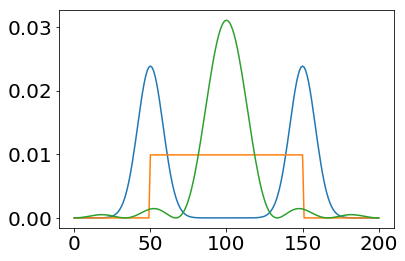

In [10]:
################
### SET DATA ###
################

frequencies = np.linspace(-1,1, 201)

freq = 30
sin_psd = np.zeros(len(frequencies))
sin_psd[freq] = 0.5 
sin_psd[-freq-1] = 0.5

freq1 = 10
freq2 = 70
sin2_psd = np.zeros(len(frequencies))
sin2_psd[freq1] = 0.25 
sin2_psd[-freq1-1] = 0.25
sin2_psd[freq2] = 0.25 
sin2_psd[-freq2-1] = 0.25

chi = 1
sinc_psd = ((1/np.abs(chi)) * rect(frequencies/chi))**2
sinc_psd /= np.sum(sinc_psd)

rect_psd = np.abs(np.sinc(3*frequencies))**2
rect_psd /= np.sum(rect_psd)

var = .007
mean = 0.5
gaus_psd = np.exp(-(frequencies-mean)**2 / (2*var) ) + np.exp(-(frequencies+mean)**2 / (2*var) )
gaus_psd /= np.sum(gaus_psd)

plt.plot(gaus_psd)
plt.plot(sinc_psd)
plt.plot(rect_psd)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


Text(-40,0,'1')

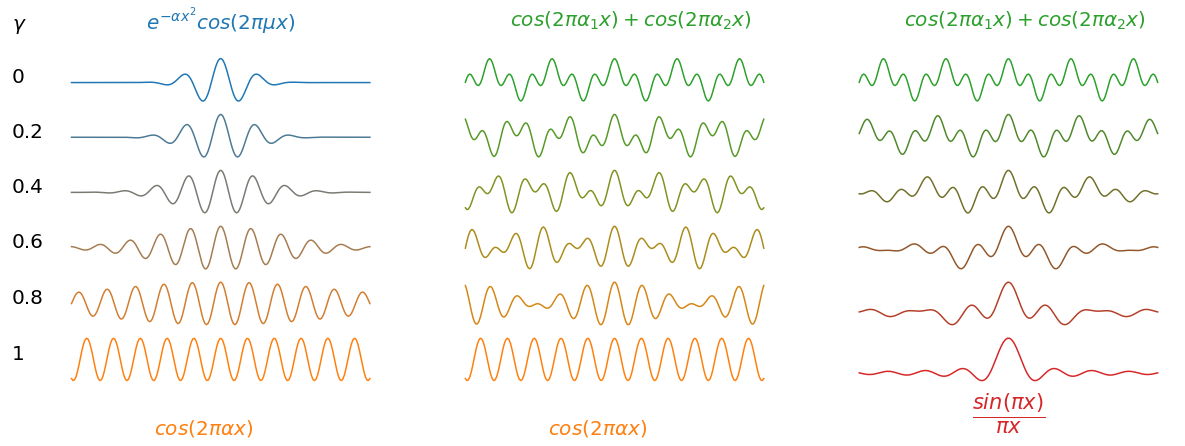

In [11]:
import matplotlib.colors as mcolors

ccc = [mcolors.to_rgb(c) for c in mcolors.TABLEAU_COLORS]
taus = np.linspace(0,1,6)
print(2*ccc[0])

column1 = []
for t in taus:
    res = [t * c2 + (1-t) * c1 for c1, c2 in zip(ccc[0], ccc[1]) ]
    res = tuple(res)
    column1.append(res)
    
column2 = []
for t in taus:
    res = [t * c2 + (1-t) * c1 for c1, c2 in zip(ccc[2], ccc[1]) ]
    res = tuple(res)
    column2.append(res)
    
column3 = []
for t in taus:
    res = [t * c2 + (1-t) * c1 for c1, c2 in zip(ccc[2], ccc[3]) ]
    res = tuple(res)
    column3.append(res)
    
colors = column1 + column2 + column3
fig, ax = plt.subplots(6, 3, figsize=(20,6))



psds = [(gaus_psd, sin_psd), (sin2_psd, sin_psd), (sin2_psd, sinc_psd)]
idx = 0
color_idx = 0 
for p1, p2 in psds:
    supports, values = get_geodesic(p2, p1, frequencies, 6)
    times = np.linspace(-50, 50, 200)
    for j, (s, v) in enumerate(zip(supports, values)):
        signal = PSD2Signal(s, times, v)
        ax[j, idx].plot(signal, color=colors[color_idx]) 
        ax[j, idx].axis('off')
        color_idx += 1
    idx += 1

    
ax[0,0].text(50,20,r'$e^{-\alpha x^2}cos(2\pi \mu x)$', fontsize=20, color=colors[0])

ax[5, 0].text(55, -5, r'$cos(2\pi\alpha x)$', fontsize=20, color=colors[5])
ax[5, 1].text(55, -5, r'$cos(2\pi\alpha x)$', fontsize=20, color=colors[5])

ax[0, 1].text(30, 5, r'$cos(2\pi\alpha_1 x) + cos(2\pi\alpha_2x)$', fontsize=20, color=colors[12])
ax[0, 2].text(30, 5, r'$cos(2\pi\alpha_1 x) + cos(2\pi\alpha_2x)$', fontsize=20, color=colors[12])

ax[5, 2].text(75, -15, r'$\frac{sin(\pi x)}{\pi x}$', fontsize=30, color=colors[17])
ax[0,0].text(-40, 20, r'$\gamma$', fontsize=20)
ax[0,0].text(-40,0, '0', color='black', fontsize=20)
ax[1,0].text(-40,0, '0.2', color='black', fontsize=20)
ax[2,0].text(-40,0, '0.4', color='black', fontsize=20)
ax[3,0].text(-40,0, '0.6', color='black', fontsize=20)
ax[4,0].text(-40,0, '0.8', color='black', fontsize=20)
ax[5,0].text(-40,0, '1', color='black', fontsize=20)


In [12]:
#fig.savefig('figures/sinc_gaus_sin.pdf', bbox='tight')

# Geodesic path between Gaussian PSDs 

0.0246740110027234
0.05062931505264387
0.08581357698005514
0.1302267967849573
0.18386897446735026
0.24674011002723395


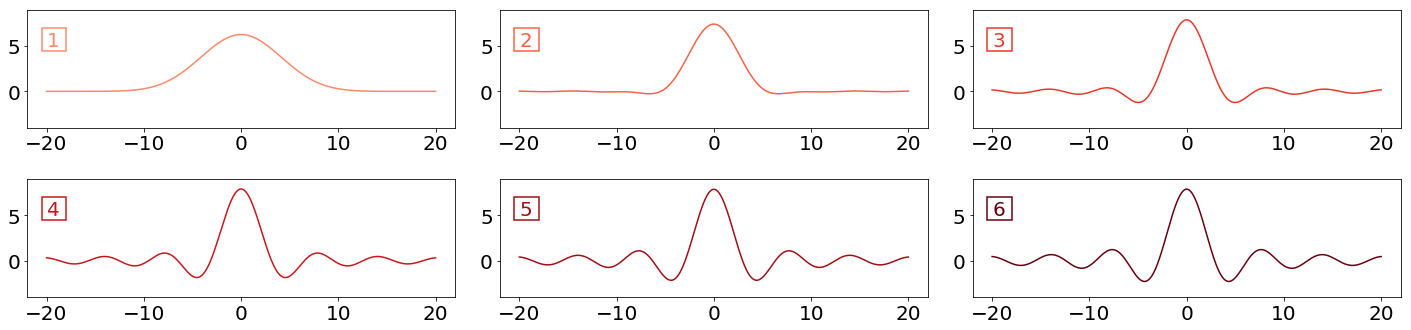

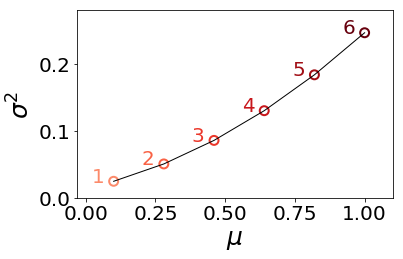

In [13]:
import matplotlib.patches as patches

# store points
mus = []
alphas = []

# initial parameters
N = 6                  # number of iterpolations
alpha1 = 0.01             # variance of first PSD
mu1 = 0.1               # mean of first PSD
alpha2 = 0.1             # variance of second PSD
mu2 = 1               # mean of second PSD


# plot settings
colors=plt.cm.Reds(np.linspace(0.4,1,N))
fig, ax = plt.subplots(2,3, figsize=(20,5))
plt.subplots_adjust(wspace=0.01, hspace=0.3)
l = 0; c = 0


# experiment
frequencies = np.linspace(-1,1,101)
taos = np.linspace(0,1,N)

for i, tao in enumerate(taos):
    
    # compute new parameters
    alpha = ((1-tao) * np.sqrt(alpha1) + tao*np.sqrt(alpha2))**2
    mu = (1-tao) * mu1 + tao * mu2
    
    # compute PSD
    variance = alpha / 4*np.pi**2
    print(variance)
    
    real_psd = np.exp(-0.5*(frequencies + mu)**2 / variance ) + np.exp(-0.5*(frequencies - mu)**2 / variance ) 
    real_psd /= np.sum(real_psd)
    
    gaus_psd = np.exp(-(frequencies - mu)**2 / (2*variance)) #+ np.exp(-(frequencies+mean)**2 / (2*var))
    gaus_psd /= np.sum(gaus_psd)
    
    mus.append(mu)
    alphas.append(variance)
    
    # compute signal
    times = np.linspace(-20, 20, 500)
    signal = np.zeros(len(times))
    for ss, rr in zip(frequencies, gaus_psd): 
        signal += np.sqrt(rr) * np.cos(ss*times)
        
    ax[l, c].plot(times, signal, color=colors[i]) 
    ax[l, c].text(-20, 5, str(i+1), color=colors[i], fontsize=20)
    ax[l, c].set_ylim([-4,9])
    # Create a Rectangle patch
    rect = patches.Rectangle((-20.5,4.5),2.5,2.5, linewidth=1.5, edgecolor=colors[i], facecolor='none')
    ax[l, c].add_patch(rect)
    
    c += 1
    if c > 2:
        c = 0
        l += 1
   
    fig.tight_layout()
    fig.savefig('figures/gaussian_interpolation.pdf')

plt.figure()
plt.plot(mus, alphas, linewidth=1, color='black')
plt.xlabel(r'$\mu$', fontsize=25)
plt.ylabel(r'$\sigma^2$', fontsize=25)
for i, (mu, alpha) in enumerate(zip(mus, alphas)):
    plt.scatter(mu, alpha, marker='o', linewidth=2, s=80, facecolors='none', edgecolors=colors[i])
    plt.text(mu-.08, alpha -.002,str(i+1), color=colors[i], fontsize=20)
    plt.xlim([-0.03,1.1])
    plt.ylim([0, 0.28])
plt.tight_layout()
plt.savefig('figures/geodesic_path.pdf')
plt.show()

# Principal geodesic analysis between Cosine and Sinc signals in WF

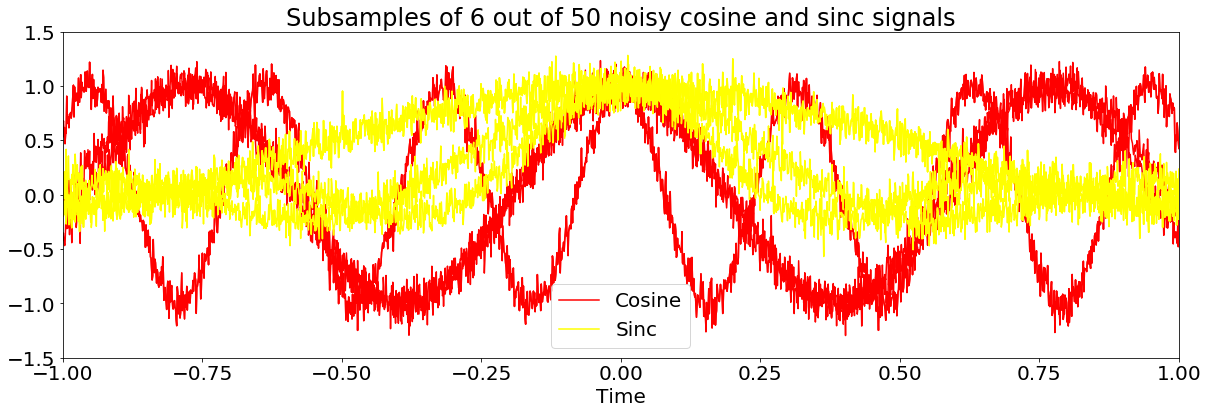

In [14]:
################
### SET DATA ###
################

times = np.linspace(-1, 1, 2000)
frequencies = np.linspace(-10,10, 2001)

nb_sig = 50
nb_sig_half = np.int(nb_sig/2)
noise1 = np.zeros((nb_sig,len(times)))
noise2 = np.zeros((nb_sig,len(times)))

unif = np.random.uniform(1,5, size = nb_sig)
sig = np.zeros((nb_sig,len(times)))
    
for j in np.arange(nb_sig_half):
    noise1[j,:] = np.random.normal(0,0.1,len(times))
    noise2[j,:] = np.random.normal(0,0.1,len(times))
    sig[j,:] = np.cos(times*2*np.pi*unif[j]) + noise1[j,:]
    sig[j+nb_sig_half,:] = np.sinc(times*unif[j+nb_sig_half]) + noise2[j,:]

# compute the NPSDs
psd = np.zeros((nb_sig,len(frequencies)))    
for j in np.arange(nb_sig):
    psd[j,:] = Signal2NPSD(frequencies, times, sig[j,:])

plt.figure(figsize=(20,6))
for j in np.arange(3):
    plt.plot(times,sig[j,:], color = 'red')
plt.plot(times,sig[j,:], color = 'red', label = 'Cosine')
for j in np.arange(25,28):
    plt.plot(times,sig[j,:], color = 'yellow')
plt.plot(times,sig[j,:], color = 'yellow', label = 'Sinc')
plt.xlabel('Time')
plt.xlim([-1, 1])
plt.ylim([-1.5, 1.5])
plt.title('Subsamples of 6 out of 50 noisy cosine and sinc signals')
plt.legend()
plt.show()


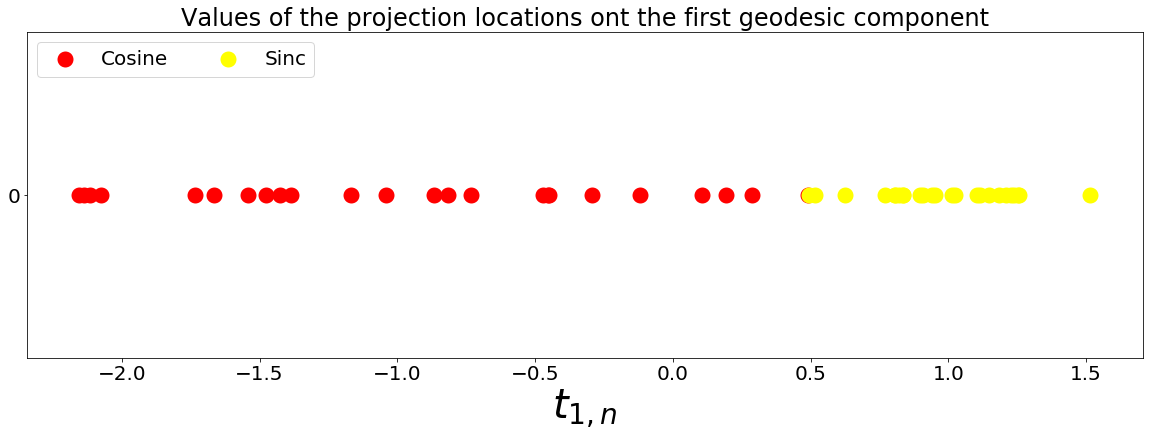

In [24]:
########################
###### GPCA in WF ######
########################

## Compute Geodesic PCA

bar, values_proj, eigenvectors, mean_matrix = perform_GPCA(psd, frequencies, nb_sig)

plt.figure(figsize=(20,6))
plt.scatter(values_proj[:nb_sig_half-1,0],np.zeros(nb_sig_half-1), color = 'red', label = 'Cosine', marker = 'o', linewidths = 10)
plt.scatter(values_proj[nb_sig_half:nb_sig,0],np.zeros(nb_sig_half), color = 'yellow', label = 'Sinc',marker = 'o', linewidths = 10)
plt.xlabel('$t_{1,n}$', fontsize=40)
plt.legend(loc='upper left', fancybox=True, ncol=2)
plt.yticks([0])
plt.title('Values of the projection locations ont the first geodesic component')
plt.show()
